In [62]:
using Distributions, StatsPlots

## Parameters to get S
Get the parameters for the N that is our frequency random varible and we know it distributes as N $\sim$ NegativeBinomial(r, p) but we also know that $\mathbb{E} = 140$ and also that $\mathbb{V} = 15²$.

Doing a little reasherch we can get that the Expected value of N is $\frac{r(1-p)}{p}$ and its variance is $\mathbb{V}(N) = \frac{r(1-p)}{p²}$
So it's only left to plug-in our values and solve for $r$ and $p$. That gives us that $r = 3920/17$ and $p = 28/45$ and we don't need to round the value of r beacuse in julia it's an expression for the distribution in case $r \in \mathbb{R}$

For Y we know that it is distributed as a $LogNormal(\mu, \sigma)$ and also that $Median(Y) = 50$ and it's $VaR_{0.995}(Y) = 5500$ 
Usign a web graphical calculator we ge to the aproximate value of: $\mu = 3.912115$ $\sigma = 2.71873$ but we can get a better approximation if we use the EDA Algorith 

In [2]:
include("EDA.jl")

EDA

In [3]:
obj_func(x) = (cdf(LogNormal(x[1], x[2]), 50) - 0.5)^2 + (cdf(LogNormal(x[1], x[2]), 5500) - 0.995)^2
eda_res = EDA(obj_func,[2,2],[4,3], difmax = 0.000000000001)

Iterando... 
...fin
Aviso: se alcanzó el máximo número de iteraciones = 1000


(x = [3.9112135714027922, 1.9519254664061245], fx = 9.076901430394942e-6, iter = 1000)

In [4]:
println(cdf(LogNormal(eda_res[1][1], eda_res[1][2]), 5500))
println(cdf(LogNormal(eda_res[1][1], eda_res[1][2]), 50))

0.9919917558975738
0.5001654353366518



Now we have the parameters for both of the distributions and we can go on

In [5]:
mu = eda_res[1][1]; sigma = eda_res[1][2]; 

freq = NegativeBinomial(3920/17 ,28/45)
sev = LogNormal(mu, sigma)

LogNormal{Float64}(μ=3.9112135714027922, σ=1.9519254664061245)

## Simulations of the accidents
Now thtat we have the parameters of the severity and the frequency distributions we now can simulate de variable S

In [6]:
function  simul_events(n)
    S = zeros(n)
    N = rand(freq, n)
    
    N_pos = findall(N .> 0)
    
    for i in N_pos
        Yi = rand(sev, N[i])
        S[i] = sum(Yi)
    end
    return(S, N)
end

simul_events (generic function with 1 method)

In [7]:
#  The exercise ask for 1M simulations
S = simul_events(10_000)

([41994.11054928828, 68565.24596422697, 67160.22193271312, 16157.344365949866, 62192.97171220104, 353377.7662894136, 86162.06584981912, 43677.02525751702, 36718.561463260245, 107406.00058847072  …  45255.71227602371, 36956.1751969352, 49826.08506982208, 50224.25615419464, 30446.267005992122, 23872.516441679876, 48928.99268106975, 33737.09227567637, 80223.43891253346, 111393.95821167307], [146, 140, 102, 108, 150, 155, 133, 169, 141, 151  …  145, 129, 144, 157, 130, 136, 142, 141, 138, 191])

The next step is to fit the distribution of S into a prior T-Student distribution as $Student(\mu_{0}, n_{0}\alpha(n_{0} + 1)^{-1}\beta^{-1}, 2\alpha)$

We viewed the for of a 3-parameter T-student distribution in class so ownow we will use it and aproximate the parameters.
remember that:

If $X \sim ST(\alpha)$ entonces $f_{X}(x | \alpha) = \frac{\Gamma(\frac{\alpha + 1}{2})}{\sqrt{\alpha\pi}\ \Gamma(\frac{\alpha}{2})} * (1 + \frac{x^{2}}{\alpha})^{\frac{\alpha +1}{2}}$ 

and usign a location-scale parametrization:

Let $\mu \in \mathbb{R}$, $\lambda > 0$ and  $T := \mu + \frac{1}{\lambda} X$
with
$\mathbb{E}[T] = \mu$,  $Median[T] = \mu$  and just in the case that  $\alpha > 2$  then   $\mathbb{V}[T] = \frac{\alpha}{(\alpha - 2)\lambda}$

So our new dsitribution function:
$f_{T}(t| \mu, \lambda, \alpha) = \sqrt{\lambda}\ f_{X}(\sqrt{\lambda} (t -\mu)\ | \alpha)$

In our case we can use these parametres as:

$\mathbb{E}(S) = \mu_{0}$ and the $\mathbb{E}(N) = n_{0}$

So our values to adjust are:

$\mu = \mu_{0}$ 

$\lambda = n_{0}\alpha(n_{0} + 1)^{-1}\beta^{-1}$ 

$\alpha = 2\alpha$ 

In [11]:
μ0 = mean(log.(S[1]))
n0 = mean(log.(S[2]))

4.9361399072998235

In [19]:
obj_func(x) = (cdf(μ0 + x[1] * TDist(x[2]), μ0) - 0.5)^2
EDA(obj_func, [1, 2], [50, 10])

Iterando... 


ArgumentError: [91mArgumentError: LocationScale: the condition σ > zero(σ) is not satisfied.[39m

In [56]:
ob2(x) = abs((cdf(LocationScale(μ0,x[1], TDist(x[2])), μ0) - 0.5))
EDA(ob2, [9,4], [13,6])

Iterando... 
...fin
Aviso: se alcanzó el máximo número de iteraciones = 1000


(x = [11.911859049563088, 4.690345983244928], fx = 0.0, iter = 1000)

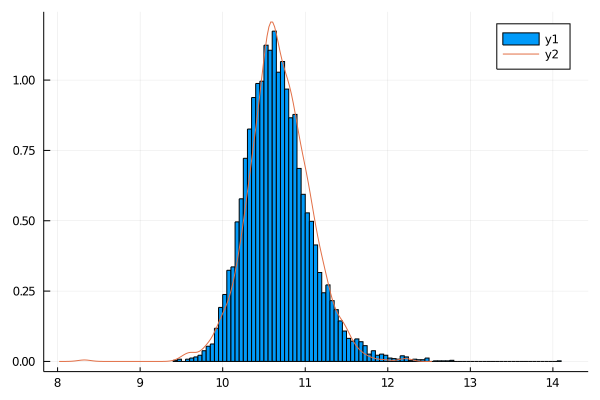

In [79]:

histogram(log.(S[1]), normalize= true)
density!(rand(LocationScale(μ0, 1/sqrt(10.205), TDist(5.71)), 1000))

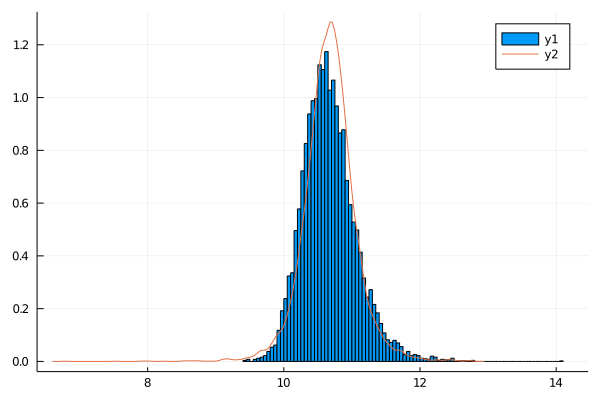

In [81]:
histogram(log.(S[1]), normalize= true)
density!(rand(LocationScale(μ0, 1/sqrt(11.911859049563088), TDist(4.69034598324492)), 10000))